In [86]:
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from skimage.io import imread, imshow
import seaborn as sns
import cv2
from glob import glob
import pandas as pd
import json
import os
import numpy as np
import os
import torch
import numpy as np
from ELD.utils import (toImg, preprocess, predict_landmarks, create_target_landmarks,
                       create_target_images, download_images_urls, downscale_images, plot_images,
                       mask_background, padImg, crop_non_tissue, downsize_and_save,
                       rescale_landmarks, pad_image_and_adjust_landmarks, corr,plot_warped_images)
from ELD.model import loadFan, crop, toGrey
from ELD.warp import Homo, Rigid, TPS

In [87]:
urlList = [
    "https://cdn.discordapp.com/attachments/592892370845040664/1233631117056409670/6423.png?ex=662fc642&is=662e74c2&hm=84bbd43770699f92bffeef007311a1919551bf82df9db2dc2f7614987a96d3d0&",
    "https://cdn.discordapp.com/attachments/592892370845040664/1233631116334993408/2720.png?ex=662fc641&is=662e74c1&hm=74f0df419d4732205d1b17b7eacd16ae862c0c695b2453e715c9eb92ef649c8f&",
    "https://cdn.discordapp.com/attachments/592892370845040664/1233631115521036348/2743.png?ex=662fc641&is=662e74c1&hm=667d5b4c1e6fdb1c79554e68c1c16aa842b1d942ea03bc48820d826b99eef9cc&",
    "https://cdn.discordapp.com/attachments/592892370845040664/1233631114824908831/3942.png?ex=662fc641&is=662e74c1&hm=060d1cb5f525425e9f98aae65f9c157f4d71b883f35df5b375f1b9b117517853&"
]
imageList = download_images_urls(urlList)



In [88]:
imageList = downscale_images(imageList)

In [90]:
for i, image in enumerate(imageList):
    if i in [0,8,9,10]:
        image = np.flip(image)

    if i in [1,3,4]:
        image = np.rot90(image,1)
        image = np.flip(image)

    imageList[i] = image



In [ ]:
imageList = mask_background(imageList)

In [ ]:
imageList = crop_non_tissue(imageList)

In [ ]:
small_imgs = downsize_and_save(imageList, "/content/run1/")

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from ELD.utils import circle_size, colors, toImg, preprocess
##theres an error at warp.py; i comment out #import ipdb; idk if this will break

from ELD.model import loadFan#, predict_landmarks
from torchgeometry.contrib import spatial_soft_argmax2d
from glob import glob
import tifffile as tiff


In [ ]:
def load_imgs(path):
    #get files with glob
    files = glob(f"{path}*")
    #sort files by number
    files = sorted(files, key=lambda x: int(x.split('/')[-1].split('.')[0]))
    #load images
    if files[0].endswith('.tif'):
        imgs = [tiff.imread(f) for f in files]
    else:
        imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) for f in files]
    return imgs


In [ ]:
!eld-train --cuda auto --data_path /content/run1/ --npts 7 --o scratch  --elastic_sigma 5 --step_size 5 --ws 0 --gamma 0.9 --angle 8 --model unimodal


#!eld-train --elastic_sigma 5 --cuda 1 --data_path /content/test/ --npts 14 --o scratch --step_size 5 --ws 0 --gamma 0.9 --angle 8 --model unimodal

[3.0]
Assigning CUDA_VISIBLE_DEVICES=0
FAN # trainable parameters: 8863623
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Number of workers is 12, and bSize is 48
Using learning rate 0.001 for FAN
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer

In [ ]:
image = torch.stack([preprocess(img) for img in small_imgs])

In [ ]:
#models 0 - 140 are valid
fan = loadFan(npoints=7,n_channels=3,path_to_model="/content/Exp_1/model_13.fan.pth")
#predict landmarks
pts = predict_landmarks(fan, image)

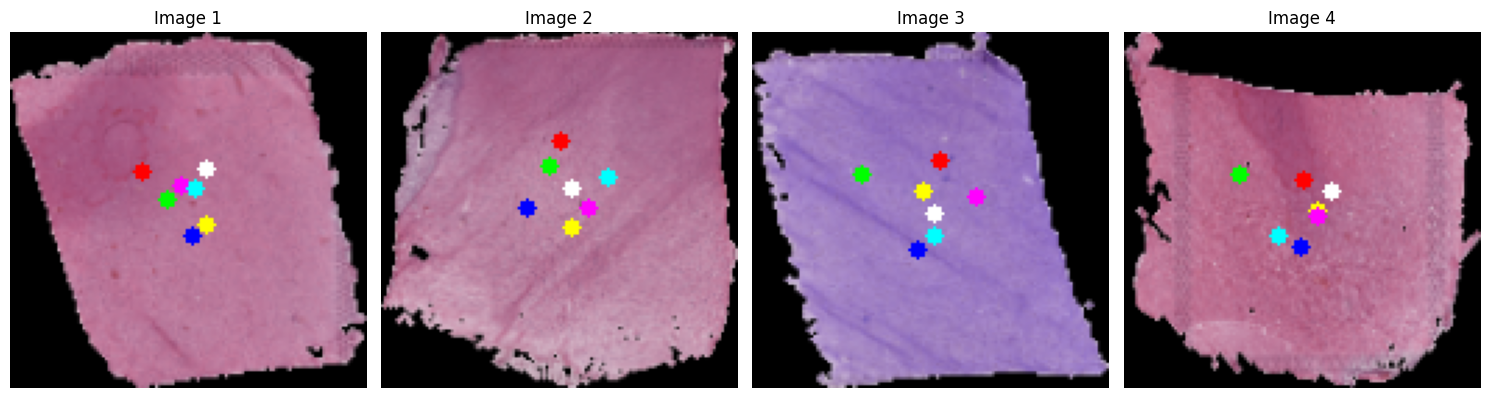

In [ ]:
#combine landmarks and image
np_img = toImg(image.cuda()[:,:3], pts, 128)


fig, axs = plt.subplots(1, 4, figsize=(15, 10))  # adjust the size as needed
axs = axs.ravel()

for i in range(len(np_img)):
    img = np_img[i]
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')  # to hide the axis

plt.tight_layout()
plt.show()



In [ ]:
#scale back landmarks to og images
scaled_pts = rescale_landmarks(pts, imageList)

In [ ]:
padded_images_torch, adjusted_landmarks = pad_image_and_adjust_landmarks(imageList, scaled_pts)

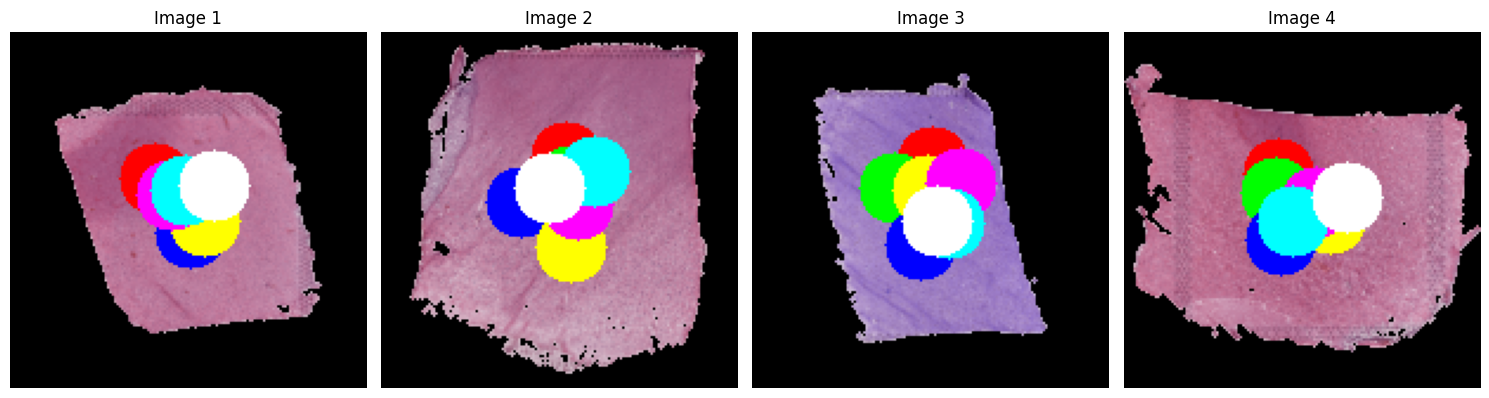

In [ ]:
#plots on og images

np_img = toImg(padded_images_torch.cuda()[:,:3], adjusted_landmarks, 5 * 128)

fig, axs = plt.subplots(1, 4, figsize=(15, 10))  # adjust the size as needed
axs = axs.ravel()

for i in range(len(np_img)):
    img = np_img[i]
    axs[i].imshow(img)
    axs[i].set_title(f"Image {i+1}")
    axs[i].axis('off')  # to hide the axis

plt.tight_layout()
plt.show()



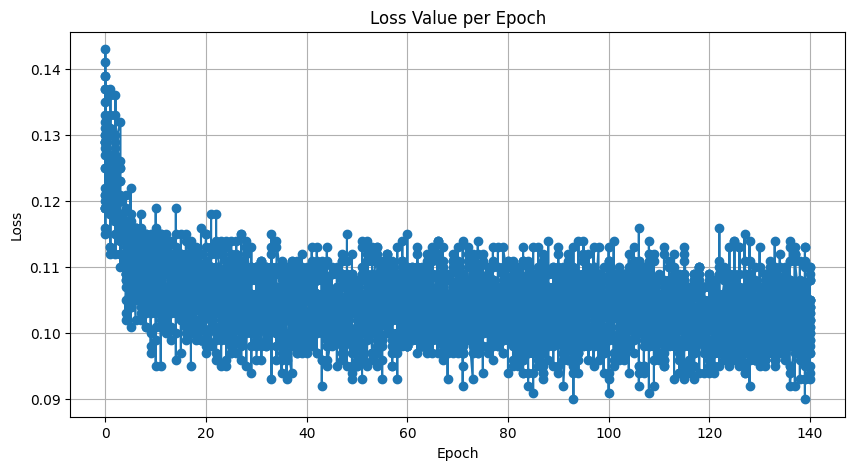

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

def plot_loss(data):
    plt.figure(figsize=(10, 5))
    plt.plot(data['Epoch'], data['Loss'], marker='o', linestyle='-')
    plt.title('Loss Value per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def parse_data_from_log(filename):
    """
    Parses the epoch and loss data from a log file.

    Args:
    filename (str): Path to the log file.

    Returns:
    pd.DataFrame: DataFrame containing epochs and corresponding loss values.
    """
    epochs = []
    losses = []

    with open(filename, 'r') as file:
        lines = file.readlines()
        for line in lines:
            match = re.search(r'Epoch \[(\d+)\]\[\d+/\d+\] .* Loss: rec (\d+\.\d+) .*', line)
            if match:
                epoch = int(match.group(1))
                loss = float(match.group(2))
                epochs.append(epoch)
                losses.append(loss)

    data = pd.DataFrame({
        'Epoch': epochs,
        'Loss': losses
    })
    return data

# File path to your log file
log_file_path = '/content/Exp_1/args_.txt'

# Parse data from log
data = parse_data_from_log(log_file_path)

# Plot the loss
plot_loss(data)
